# Analyzing data from SUS

This notebook gathers data about the brazilian SUS system. The datasets are:
1. `ubs.csv`: Basic Healthcare Units - UBS (data from 2013, http://dados.gov.br/dataset/unidades-basicas-de-saude-ubs);
2. `internacoes.csv`: Hospitalization (data from 2011, http://dados.gov.br/dataset/wms_idsus_nt_prisab).
3. `populacao.csv`: Demographic data of population by city in Brazil (data from 2020, https://sidra.ibge.gov.br/tabela/6579).

The main goal is to find regions that could benefit more from improved public healthcare.

First, those datasets headers were edited to be easier to work with. Also, extra data attached to the CSV (explanation texts, titles) were removed.

## Read data

First, the data is read from the CSV files. Some data needs normalization, such as splitting information from city and state.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os

# Regex
import re

# Plotting
import matplotlib.pyplot as plt

# K-means
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

import math
from numpy.random import seed
seed(1)

from utils import *

SCATTER_SIZE=2
DEFAULT_FIGURE_SIZE=(12,12)

In [2]:
print(os.listdir("./"))

['analise-sus.ipynb', '.DS_Store', 'requirements.txt', 'ubs.csv', 'demo.png', '__pycache__', 'populacao.csv', 'cadastro_saude.csv', 'utils.py', 'sp-analyzis.ipynb', '.ipynb_checkpoints', '.git', 'internacoes.csv']


In [3]:
raw_ubs = pd.read_csv('./ubs.csv')
raw_ubs.shape

(37690, 13)

In [4]:
def grade_ubs_scores(ubs, column):
    ubs.loc[ubs[column] == 'Desempenho mediano ou  um pouco abaixo da média', column] = 0
    ubs.loc[ubs[column] == 'Desempenho acima da média', column] = 5
    ubs.loc[ubs[column] == 'Desempenho muito acima da média', column] = 10

In [5]:
grade_ubs_scores(raw_ubs, 'dsc_estrut_fisic_ambiencia')
grade_ubs_scores(raw_ubs, 'dsc_adap_defic_fisic_idosos')
grade_ubs_scores(raw_ubs, 'dsc_equipamentos')
grade_ubs_scores(raw_ubs, 'dsc_medicamentos')

In [6]:
hospitalizations = pd.read_csv('./internacoes.csv')
hospitalizations.shape

(5565, 3)

In [7]:
population_raw = pd.read_csv('./populacao.csv')
population_raw.shape

(5570, 2)

In [8]:
population_raw.head()

,dsc_cidade,populacao
0,Alta Floresta D'Oeste (RO),22728
1,Ariquemes (RO),109523
2,Cabixi (RO),5188
3,Cacoal (RO),85893
4,Cerejeiras (RO),16204


In [9]:
# Normalize data from population

# Splits city and state
population = population_raw['dsc_cidade'].str.extract('(?P<dsc_cidade>.*)\ \((?P<estado>[A-Z]{2})\)', expand=True)

population['populacao'] = population_raw["populacao"]

population.head()

,dsc_cidade,estado,populacao
0,Alta Floresta D'Oeste,RO,22728
1,Ariquemes,RO,109523
2,Cabixi,RO,5188
3,Cacoal,RO,85893
4,Cerejeiras,RO,16204


In [10]:
states = population['estado'].unique()
states.sort()
states

array(['AC', 'AL', 'AM', 'AP', 'BA', 'CE', 'DF', 'ES', 'GO', 'MA', 'MG',
       'MS', 'MT', 'PA', 'PB', 'PE', 'PI', 'PR', 'RJ', 'RN', 'RO', 'RR',
       'RS', 'SC', 'SE', 'SP', 'TO'], dtype=object)

In [11]:
# Calculate population of each state for later
states_population = []

for state in states:
    cities = population[population['estado'] == state]
    rows_sum = cities.sum(axis = 0, skipna = True)
    states_population.append(rows_sum['populacao'])

## Merging data

The datasets are initiallt disjoint. In order to analyze the data, the datasets are joined using the city name as the key.

In [12]:
X = 'vlr_longitude'
Y = 'vlr_latitude'

raw_ubs.head()

,vlr_latitude,vlr_longitude,cod_munic,cod_cnes,nom_estab,dsc_endereco,dsc_bairro,dsc_cidade,dsc_telefone,dsc_estrut_fisic_ambiencia,dsc_adap_defic_fisic_idosos,dsc_equipamentos,dsc_medicamentos
0,-10.911237,-37.062078,280030,3492,US OSWALDO DE SOUZA,TV ADALTO BOTELHO,GETULIO VARGAS,Aracaju,7931791326,5,10,0,5
1,-9.485943,-35.857573,270770,6685315,USF ENFERMEIRO PEDRO JACINTO AREA 09,R 15 DE AGOSTO,CENTRO,Rio Largo,Não se aplica,0,0,0,0
2,-23.896000,-53.410000,411885,6811299,UNIDADE DE ATENCAO PRIMARIA SAUDE DA FAMILIA,RUA GUILHERME BRUXEL,CENTRO,Perobal,4436251462,10,10,0,10
3,-16.447874,-41.009860,313580,6335616,POSTO DE SAUDE DE BOM JESUS DA ALDEIA,RUA TEOFILO OTONI,ALDEIA,Jequitinhonha,3337411423,0,5,0,0
4,-6.573311,-35.107605,250930,6662226,POSTO ANCORA URUBA,RODOVIA PB N 065,SITIO,Mataraca,Não se aplica,5,5,0,0


In [13]:
hospitalizations.head()

,dsc_cidade,nota,data_ref
0,Engenheiro Coelho,10.000000,2011-12-31
1,São José do Piauí,4.489151,2011-12-31
2,Jataí,9.005388,2011-12-31
3,Carolina,3.805439,2011-12-31
4,Abre Campo,5.862776,2011-12-31


In [14]:
population.head()

,dsc_cidade,estado,populacao
0,Alta Floresta D'Oeste,RO,22728
1,Ariquemes,RO,109523
2,Cabixi,RO,5188
3,Cacoal,RO,85893
4,Cerejeiras,RO,16204


In [15]:
ubs_with_quality = pd.merge(left=raw_ubs, right=hospitalizations, left_on='dsc_cidade', right_on='dsc_cidade')
ubs = pd.merge(left=ubs_with_quality, right=population, left_on='dsc_cidade', right_on='dsc_cidade')
ubs

,vlr_latitude,vlr_longitude,cod_munic,cod_cnes,nom_estab,dsc_endereco,dsc_bairro,dsc_cidade,dsc_telefone,dsc_estrut_fisic_ambiencia,dsc_adap_defic_fisic_idosos,dsc_equipamentos,dsc_medicamentos,nota,data_ref,estado,populacao
0,-10.911237,-37.062078,280030,3492,US OSWALDO DE SOUZA,TV ADALTO BOTELHO,GETULIO VARGAS,Aracaju,7931791326,5,10,0,5,10.000000,2011-12-31,SE,664908
1,-10.968969,-37.082076,280030,2291,US GERALDO MAGELA DE MENEZES SAO CONRADO,RUA CENTRAL 4,SAO CONRADO,Aracaju,7931791704,10,10,0,5,10.000000,2011-12-31,SE,664908
2,-10.903630,-37.078986,280030,2542,US JOAO CARDOSO NASCIMENTO JUNIOR JOSE CONRADO...,RUA ALAGOAS,JOSE CONRADO DE ARAU,Aracaju,7931792261,5,5,0,0,10.000000,2011-12-31,SE,664908
3,-10.959978,-37.078106,280030,2445,US HUMBERTO MOURAO GUIMARAES SAO CONRADO,RUA A,SAO CONRADO,Aracaju,7931791708,0,10,0,5,10.000000,2011-12-31,SE,664908
4,-10.894167,-37.079308,280030,2429,US JOSE MACHADO DE SOUZA SANTOS DUMONT,RUA MARECHAL AURELIANO,SANTOS DUMONT,Aracaju,7932457815,10,5,10,5,10.000000,2011-12-31,SE,664908
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53310,-22.435992,-47.719803,352110,2785331,CENTRO DE SAUDE III IPEUNA,AVN TRES,CENTRO,Ipeúna,1935761224,0,10,0,0,10.000000,2011-12-31,SP,7687
53311,-29.422084,-51.515279,431935,2226154,POSTO DE SAUDE SAO PEDRO DA SERRA,AVENIDA DUQUE DE CAXIAS,CENTRO,São Pedro da Serra,5136451174,10,0,10,10,10.000000,2011-12-31,RS,3842
53312,-22.661941,-52.864151,410710,2782820,NIS II DIAMANTE DO NORTE,RUA REYNALDO MASSI,CENTRO,Diamante do Norte,4434291442,0,0,5,10,6.722952,2011-12-31,PR,5030
53313,-18.591056,-41.486349,316105,2102862,UNIDADE DE SAUDE SENHORA SEBASTIANA ROSA DE JESUS,RUA JUAREZ RIBEIRO PORTES,CENTRO,São Félix de Minas,(33)32469066,5,10,5,10,6.318068,2011-12-31,MG,3362


In [16]:
ubs['nota_infra'] = (ubs['dsc_estrut_fisic_ambiencia'] + ubs['dsc_adap_defic_fisic_idosos']
                    + ubs['dsc_equipamentos'] + ubs['dsc_medicamentos']) / 4
ubs['nota_potencial'] = (ubs['nota_infra'] + ubs['nota']) / 2
ubs['nota_qualidade'] = (ubs['nota_infra'] + (10 - ubs['nota'])) / 2

ubs

,vlr_latitude,vlr_longitude,cod_munic,cod_cnes,nom_estab,dsc_endereco,dsc_bairro,dsc_cidade,dsc_telefone,dsc_estrut_fisic_ambiencia,dsc_adap_defic_fisic_idosos,dsc_equipamentos,dsc_medicamentos,nota,data_ref,estado,populacao,nota_infra,nota_potencial,nota_qualidade
0,-10.911237,-37.062078,280030,3492,US OSWALDO DE SOUZA,TV ADALTO BOTELHO,GETULIO VARGAS,Aracaju,7931791326,5,10,0,5,10.000000,2011-12-31,SE,664908,5,7.5,2.5
1,-10.968969,-37.082076,280030,2291,US GERALDO MAGELA DE MENEZES SAO CONRADO,RUA CENTRAL 4,SAO CONRADO,Aracaju,7931791704,10,10,0,5,10.000000,2011-12-31,SE,664908,6.25,8.125,3.125
2,-10.903630,-37.078986,280030,2542,US JOAO CARDOSO NASCIMENTO JUNIOR JOSE CONRADO...,RUA ALAGOAS,JOSE CONRADO DE ARAU,Aracaju,7931792261,5,5,0,0,10.000000,2011-12-31,SE,664908,2.5,6.25,1.25
3,-10.959978,-37.078106,280030,2445,US HUMBERTO MOURAO GUIMARAES SAO CONRADO,RUA A,SAO CONRADO,Aracaju,7931791708,0,10,0,5,10.000000,2011-12-31,SE,664908,3.75,6.875,1.875
4,-10.894167,-37.079308,280030,2429,US JOSE MACHADO DE SOUZA SANTOS DUMONT,RUA MARECHAL AURELIANO,SANTOS DUMONT,Aracaju,7932457815,10,5,10,5,10.000000,2011-12-31,SE,664908,7.5,8.75,3.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53310,-22.435992,-47.719803,352110,2785331,CENTRO DE SAUDE III IPEUNA,AVN TRES,CENTRO,Ipeúna,1935761224,0,10,0,0,10.000000,2011-12-31,SP,7687,2.5,6.25,1.25
53311,-29.422084,-51.515279,431935,2226154,POSTO DE SAUDE SAO PEDRO DA SERRA,AVENIDA DUQUE DE CAXIAS,CENTRO,São Pedro da Serra,5136451174,10,0,10,10,10.000000,2011-12-31,RS,3842,7.5,8.75,3.75
53312,-22.661941,-52.864151,410710,2782820,NIS II DIAMANTE DO NORTE,RUA REYNALDO MASSI,CENTRO,Diamante do Norte,4434291442,0,0,5,10,6.722952,2011-12-31,PR,5030,3.75,5.23648,3.51352
53313,-18.591056,-41.486349,316105,2102862,UNIDADE DE SAUDE SENHORA SEBASTIANA ROSA DE JESUS,RUA JUAREZ RIBEIRO PORTES,CENTRO,São Félix de Minas,(33)32469066,5,10,5,10,6.318068,2011-12-31,MG,3362,7.5,6.90903,5.59097


## Looking to the data

Here we plot the localization of the Basic Healthcare Units and the conditions of the UBS according to the parameters of the dataset. Each state is represented by a different color.

In [17]:
def color_by_state(ubs):
    cmap = plt.get_cmap('viridis')
    colors = cmap(np.linspace(0, 1, len(states)))
    color_dict = dict(zip(states, colors))  
    ubs.loc[:, 'cor'] = ubs['estado'].apply(lambda x: color_dict[x])
    
# The max for this dataset is 7.8
# 5 levels: x = 0, x <= 2.5, 2.5 < 5 < 6, 6 <= x < 7, x > 7
def ubs_quality_index(x):
    if x == 0:
        index =0
    elif x <= 2.5:
        index = 1
    elif x < 6:
        index = 2
    elif x < 7:
        index = 3
    else:
        index = 4
        
    return index

def color_by_quality(ubs, column, label_dict=['1. Péssimo', '2. Ruim', '3. Médio', '4. Bom', '5. Excelente']):
    cmap = plt.get_cmap('Set1')
    colors = cmap(np.linspace(0, 0.6, 5))
    color_dict = dict(zip(range(5), colors))
    priority_dict =  [3, 2, 0, 1, 4]
    
    indexes = ubs[column].apply(lambda x: ubs_quality_index(x))
    ubs['label_prioridade'] = indexes.apply(lambda x: priority_dict[x])
    ubs['label'] = indexes.apply(lambda x: label_dict[x])
    ubs['cor'] = indexes.apply(lambda x: color_dict[x])

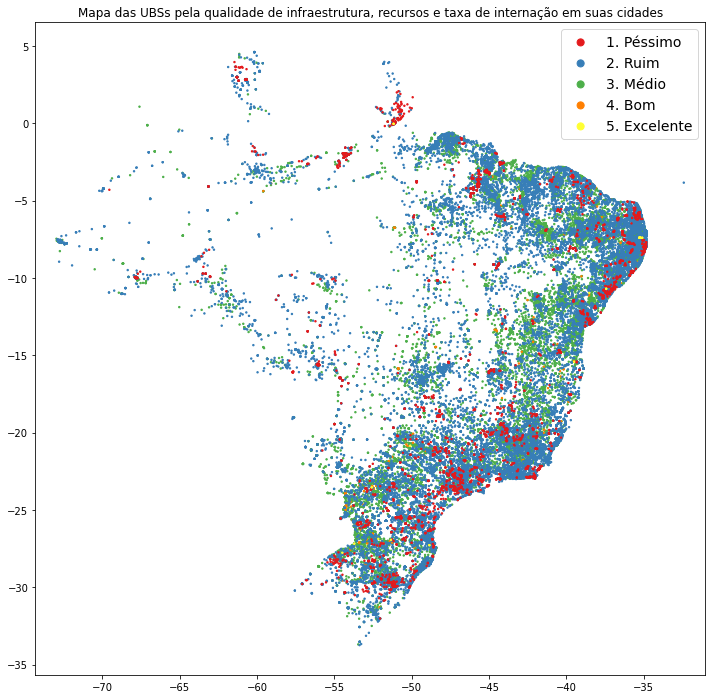

In [18]:
color_by_quality(ubs, 'nota_qualidade')

figure_size()
points = print_map(ubs, show=False, alpha=1, x=X, y=Y)

legend_for_map()
    
plt.title('Mapa das UBSs pela qualidade de infraestrutura, recursos e taxa de internação em suas cidades')
plt.show()

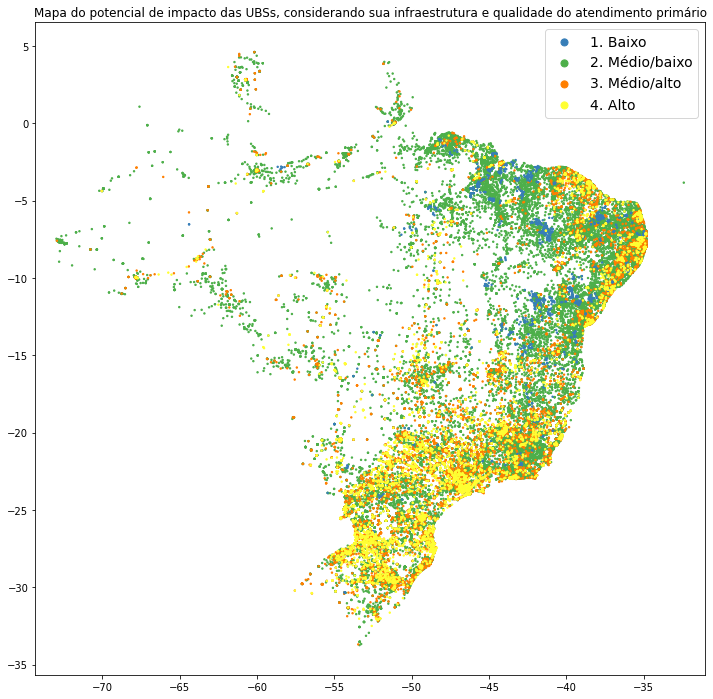

In [19]:
color_by_quality(ubs, 'nota_potencial', label_dict=['', '1. Baixo', '2. Médio/baixo', '3. Médio/alto', '4. Alto'])

figure_size()
points = print_map(ubs, show=False, alpha=1, x=X, y=Y)

legend_for_map()
    
plt.title('Mapa do potencial de impacto das UBSs, considerando sua infraestrutura e qualidade do atendimento primário')
plt.show()

<AxesSubplot:>

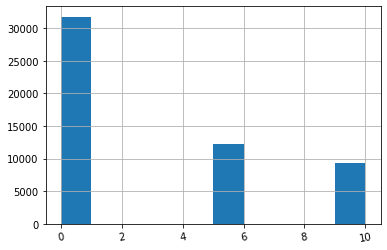

In [20]:
ubs['dsc_estrut_fisic_ambiencia'].hist(xlabelsize=10, xrot=10)

<AxesSubplot:>

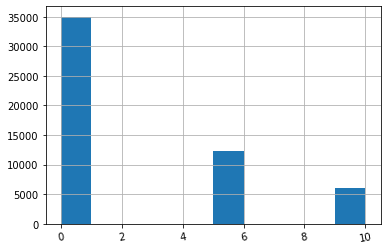

In [21]:
ubs['dsc_adap_defic_fisic_idosos'].hist(xlabelsize=10, xrot=10)

<AxesSubplot:>

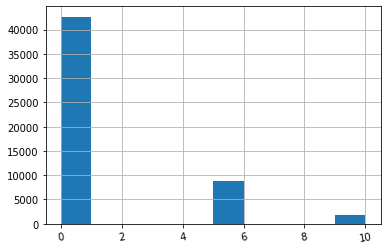

In [22]:
ubs['dsc_equipamentos'].hist(xlabelsize=10, xrot=10)

<AxesSubplot:>

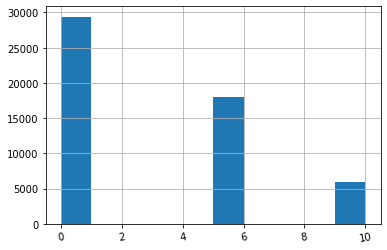

In [23]:
ubs['dsc_medicamentos'].hist(xlabelsize=10, xrot=10)

To make sure we are looking for the healthcare conditions in the worst regions, we select only the UBS with worst conditions in infrastructure in every parameter.

In [24]:
selected_ubs = ubs[ubs['nota_infra'] == 0]
selected_ubs

,vlr_latitude,vlr_longitude,cod_munic,cod_cnes,nom_estab,dsc_endereco,dsc_bairro,dsc_cidade,dsc_telefone,dsc_estrut_fisic_ambiencia,...,nota,data_ref,estado,populacao,nota_infra,nota_potencial,nota_qualidade,label_prioridade,label,cor
20,-10.869931,-37.056541,280030,3603,US EUNICE BARBOSA DE OLIVEIRA,AV EUCLIDES FIGUEIREDO,COQUEIRAL,Aracaju,7931793415,0,...,10.000000,2011-12-31,SE,664908,0,5,0,0,2. Médio/baixo,"[0.30196078431372547, 0.6862745098039216, 0.29..."
43,-9.485943,-35.857573,270770,6685315,USF ENFERMEIRO PEDRO JACINTO AREA 09,R 15 DE AGOSTO,CENTRO,Rio Largo,Não se aplica,0,...,9.193679,2011-12-31,AL,75394,0,4.59684,0.40316,0,2. Médio/baixo,"[0.30196078431372547, 0.6862745098039216, 0.29..."
45,-9.452587,-35.849032,270770,2721554,USF DR GASTAO OITICICA,USINA SANTA CLOTILDE,ZONA RURAL,Rio Largo,8232618027,0,...,9.193679,2011-12-31,AL,75394,0,4.59684,0.40316,0,2. Médio/baixo,"[0.30196078431372547, 0.6862745098039216, 0.29..."
46,-9.525576,-35.797706,270770,2719843,USF PROF JOSE CARLOS DA SILVA,LOTEAMENTO PALMARES,TABDO PINTO,Rio Largo,8233524622,0,...,9.193679,2011-12-31,AL,75394,0,4.59684,0.40316,0,2. Médio/baixo,"[0.30196078431372547, 0.6862745098039216, 0.29..."
47,-9.529041,-35.799358,270770,2704986,USF BENEDITO LOPES,LOT PARQUE SANTA TEREZA,TABULEIRO DO PINTO,Rio Largo,33738173,0,...,9.193679,2011-12-31,AL,75394,0,4.59684,0.40316,0,2. Médio/baixo,"[0.30196078431372547, 0.6862745098039216, 0.29..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53171,-28.269839,-49.760921,420250,2300974,UNIDADE SANITARIA MANTIQUEIRA,INTERIOR,MANTIQUEIRA,Bom Jardim da Serra,(49)2320195,0,...,7.554645,2011-12-31,SC,4772,0,3.77732,1.22268,0,2. Médio/baixo,"[0.30196078431372547, 0.6862745098039216, 0.29..."
53184,-21.072743,-48.410912,355365,2091909,UNIDADE BASICA DE SAUDE DE TAQUARAL CAETANO PI...,RUA CENTRAL,CENTRO,Taquaral,1639586195,0,...,10.000000,2011-12-31,SP,2813,0,5,0,0,2. Médio/baixo,"[0.30196078431372547, 0.6862745098039216, 0.29..."
53212,-28.893335,-52.037237,430070,2251191,POSTO DE SAUDE DE ANTA GORDA,LINHA ITAPUCA,INTERIOR,Anta Gorda,5137561147,0,...,8.709950,2011-12-31,RS,5961,0,4.35498,0.645025,0,2. Médio/baixo,"[0.30196078431372547, 0.6862745098039216, 0.29..."
53226,-11.338159,-49.262867,170730,2467550,CENTRO DE SAUDE LUISA PINHEIRO BARROS DUERE,AVN JADER PIRES,CENTRO,Dueré,6333581180,0,...,5.385258,2011-12-31,TO,4686,0,2.69263,2.30737,0,2. Médio/baixo,"[0.30196078431372547, 0.6862745098039216, 0.29..."


In [25]:
bad_grade_ubs_count = ubs[ubs['nota'] >= 9.5].shape[0]
worst_ubs_count = selected_ubs[selected_ubs['nota'] >= 9.5].shape[0]

print('Total de UBSs: %d' % ubs.shape[0])
print('UBSs com nota maior que 9.5: %d' % bad_grade_ubs_count)
print('UBSs com infraestrutura de nota mínima em todas as 4 categorias: %d' % selected_ubs.shape[0])
print('UBSs com pior infraestrutura e nota maior que 9.5: %d' % worst_ubs_count)

state_ubs_count_list = []

print("\n===== Por Estado ====")
for state in states:
    state_ubs = ubs[ubs['estado'] == state]
    state_ubs_count = state_ubs.shape[0]
    mean = state_ubs['nota'].mean()
    std = state_ubs['nota'].std()
    
    state_ubs_count_list.append(state_ubs_count)
    
    print('UBSs no Estado do %s: %d (nota média: %0.1f±%0.1f)' % (state, state_ubs_count, mean, std))

Total de UBSs: 53315
UBSs com nota maior que 9.5: 18427
UBSs com infraestrutura de nota mínima em todas as 4 categorias: 15175
UBSs com pior infraestrutura e nota maior que 9.5: 4207

===== Por Estado ====
UBSs no Estado do AC: 292 (nota média: 7.4±1.8)
UBSs no Estado do AL: 1557 (nota média: 7.6±1.5)
UBSs no Estado do AM: 577 (nota média: 8.3±1.7)
UBSs no Estado do AP: 182 (nota média: 9.0±2.0)
UBSs no Estado do BA: 5042 (nota média: 7.0±1.8)
UBSs no Estado do CE: 2423 (nota média: 8.2±1.6)
UBSs no Estado do DF: 132 (nota média: 9.5±0.0)
UBSs no Estado do ES: 906 (nota média: 8.6±1.5)
UBSs no Estado do GO: 1584 (nota média: 7.9±1.5)
UBSs no Estado do MA: 2797 (nota média: 6.9±1.8)
UBSs no Estado do MG: 5876 (nota média: 8.3±1.6)
UBSs no Estado do MS: 830 (nota média: 7.7±1.7)
UBSs no Estado do MT: 967 (nota média: 8.2±1.8)
UBSs no Estado do PA: 1633 (nota média: 7.1±1.4)
UBSs no Estado do PB: 3446 (nota média: 7.7±1.7)
UBSs no Estado do PE: 2789 (nota média: 8.3±1.6)
UBSs no Estado do

In [26]:
ubs_space = selected_ubs.iloc[:,0:2]

Now that we know the worst ones, we plot a graph with them clusterized by region. We let

In [27]:
N_REGIONS = 26
kmeans = KMeans(n_clusters=N_REGIONS).fit(ubs_space)
        
centroids = kmeans.cluster_centers_

closest, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, ubs_space)
closest

array([12041,  4101, 11071, 12175,  9711, 12851,  1523, 10710,  6423,
        5960, 11447,  7801,  5724,  5265,  6426, 11605, 14705, 11268,
        4317,  6531,  3315,   115, 13877,  4430,  2121,  6805])

### Map by clustering

In [28]:
color_by_state(selected_ubs)
ubs_space['cor'] = selected_ubs['cor']
ubs_space['dsc_cidade'] = selected_ubs['dsc_cidade']

/usr/local/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


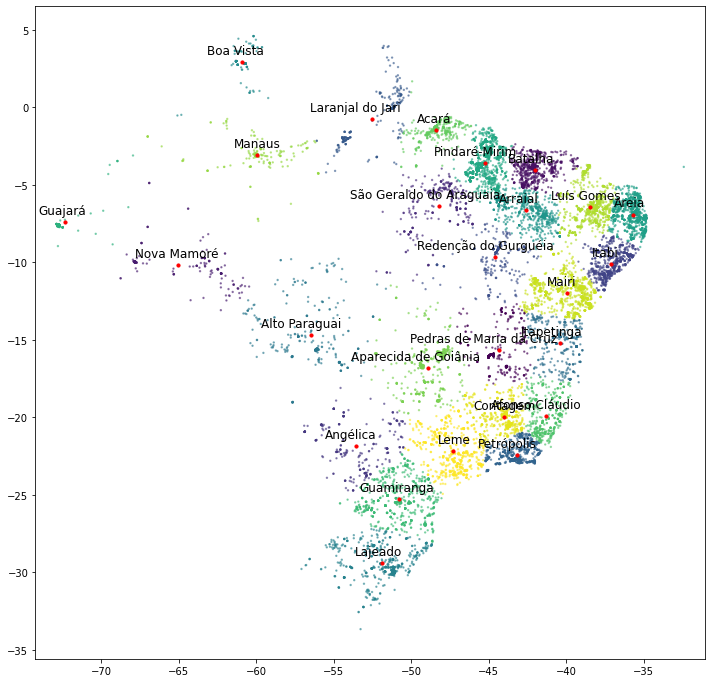

In [29]:
figure_size()
plt.axis('equal')
plt.scatter(ubs_space[X], ubs_space[Y], c= kmeans.labels_.astype(float), s=SCATTER_SIZE, alpha=0.5)
plt.scatter(centroids[:, 1], centroids[:, 0], c='red', s=10)

for i in range(len(centroids)):
    index = closest[i]
    city = ubs_space.iloc[index]['dsc_cidade']
    
    x = centroids[i, 1]-(0.25*len(city))
    y = centroids[i, 0]+0.5
    
    plt.text(x, y, city, fontsize=12)
    

plt.show()

###  Map by state

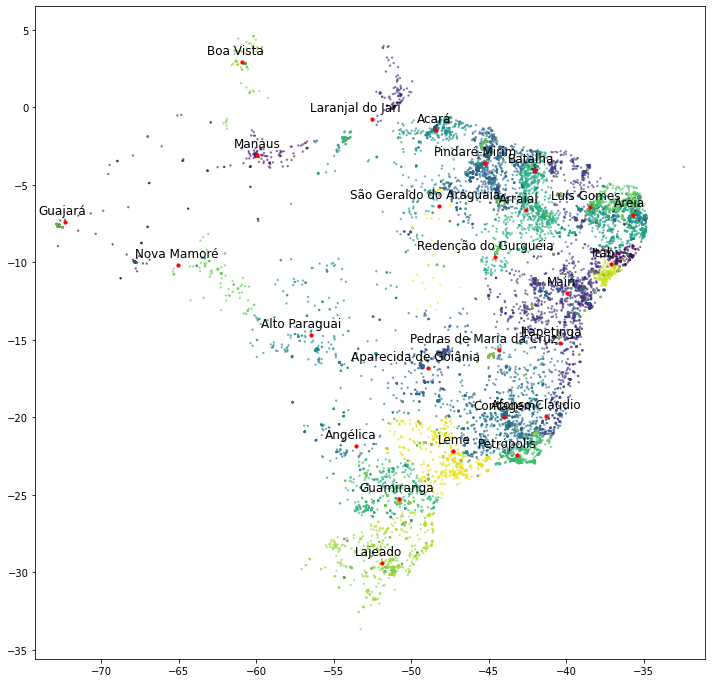

In [30]:
figure_size()
print_map(ubs_space, show=False, x=X, y=Y)
plt.scatter(centroids[:, 1], centroids[:, 0], c='red', s=10)

for i in range(len(centroids)):
    index = closest[i]
    city = ubs_space.iloc[index]['dsc_cidade']
    
    x = centroids[i, 1]-(0.25*len(city))
    y = centroids[i, 0]+0.5
    
    plt.text(x, y, city, fontsize=12)

plt.show()

In [31]:
selected_ubs.iloc[closest]

,vlr_latitude,vlr_longitude,cod_munic,cod_cnes,nom_estab,dsc_endereco,dsc_bairro,dsc_cidade,dsc_telefone,dsc_estrut_fisic_ambiencia,...,nota,data_ref,estado,populacao,nota_infra,nota_potencial,nota_qualidade,label_prioridade,label,cor
40755,-15.612720,-44.388843,314915,6793223,UNIDADE BASICA DE SAUDE DONA QUITA PEREIRA,RUA SAFIRA,VILA MARIA,Pedras de Maria da Cruz,3892139676,0,...,7.418313,2011-12-31,MG,12212,0,3.70916,1.29084,0,2. Médio/baixo,"[0.169646, 0.456262, 0.55803, 1.0]"
13205,-4.051681,-42.007792,220150,2669021,PS LAGES,LAGES,ZONA RURAL,Batalha,Não se aplica,0,...,5.060325,2011-12-31,PI,26905,0,2.53016,2.46984,0,2. Médio/baixo,"[0.146616, 0.67305, 0.508936, 1.0]"
37399,-10.404160,-65.334063,110033,2806940,CENTRO DE SAUDE PLANALTO NOVA MAMORE,AVENIDA CECILIA MEIRELES,CENTRO,Nova Mamoré,6935443194,0,...,5.619486,2011-12-31,RO,31392,0,2.80974,2.19026,0,2. Médio/baixo,"[0.404001, 0.800275, 0.362552, 1.0]"
41279,-6.400727,-48.555236,150745,2333341,UNIDADE DE SAUDE DA FAMILIA BEIRA RIO,TRAVESSA DO INCRA,BEIRA RIO,São Geraldo do Araguaia,Não se aplica,0,...,6.198000,2011-12-31,PA,24705,0,3.099,1.901,0,2. Médio/baixo,"[0.127568, 0.566949, 0.550556, 1.0]"
32534,-22.152611,-53.768570,500085,2376628,PROGRAMA SAUDE DA FAMILIA DE ANGELICA,AVE PADRE AQUILINO FRANCISCHET,VILA ESPERANCA,Angélica,6734461563,0,...,5.214423,2011-12-31,MS,10932,0,2.60721,2.39279,0,2. Médio/baixo,"[0.154815, 0.493313, 0.55784, 1.0]"
43757,-10.087616,-37.139132,280310,2477785,PS POVOADO BOA HORA,POVOAD0,ZONA RURAL,Itabi,Não se aplica,0,...,8.567123,2011-12-31,SE,4886,0,4.28356,0.716439,0,2. Médio/baixo,"[0.804182, 0.882046, 0.114965, 1.0]"
5439,-9.489237,-44.585309,220870,2404591,UNID DA FAMILIA DA PLANALTINA,RUA DO FERREIRO,PLANALTINA,Redenção do Gurguéia,Não se aplica,0,...,5.799162,2011-12-31,PI,8796,0,2.89958,2.10042,0,2. Médio/baixo,"[0.146616, 0.67305, 0.508936, 1.0]"
36146,-0.840776,-52.521837,160027,4006496,PMLAJ UBS DR LELIO SILVA,AV EMILIO MEDICE,AGRESTE,Laranjal do Jari,9636212811,0,...,7.289705,2011-12-31,AP,51362,0,3.64485,1.35515,0,2. Médio/baixo,"[0.280868, 0.160771, 0.472899, 1.0]"
21482,-22.383689,-43.119450,330390,2275732,POSTO DE SAUDE DA LAJINHA,ESTRADA DAS ARCAS,ITAIPAVA,Petrópolis,22225196,0,...,10.000000,2011-12-31,RJ,306678,0,5,0,0,2. Médio/baixo,"[0.252899, 0.742211, 0.448284, 1.0]"
19557,-15.246223,-40.249035,291640,2510014,UBS FUNDACAO JUVINO OLIVEIRA,PCA DAYRI WALLEY,CENTRO,Itapetinga,(77) 2611257,0,...,7.919793,2011-12-31,BA,76795,0,3.9599,1.0401,0,2. Médio/baixo,"[0.271828, 0.209303, 0.504434, 1.0]"


Looking into this data, we realize that many of those UBS are in a rural area. This might be an insight for the future; a better primary care in these areas avoid issues related to moving pacients.

## Worst UBS in primary care

Here we filtered the UBS even further by choosing only the ones with really poor number of hospitalizations due o inefficient primary care (score of at least 9.5).

In [32]:
bad_primary = selected_ubs['nota'] >= 9.5
bad_primary_ubs = selected_ubs[bad_primary]
bad_primary_ubs = bad_primary_ubs.sort_values(by=['estado'])

bad_primary_ubs

,vlr_latitude,vlr_longitude,cod_munic,cod_cnes,nom_estab,dsc_endereco,dsc_bairro,dsc_cidade,dsc_telefone,dsc_estrut_fisic_ambiencia,...,nota,data_ref,estado,populacao,nota_infra,nota_potencial,nota_qualidade,label_prioridade,label,cor
38114,-10.078475,-67.055655,120001,3006166,UNIDADE DE SAUDE DA FAMILIA NORTON VITORINO BOHEN,RUA PARANA,CENTRO,Acrelândia,6832351426,0,...,9.866406,2011-12-31,AC,15490,0,4.9332,0.0667969,0,2. Médio/baixo,"[0.267004, 0.004874, 0.329415, 1.0]"
37681,-9.592481,-67.543216,120080,2001128,UNIDADE DE SAUDE DA FAMILIA MARIA SOLEDADE SOA...,ROD AC 10KM 56,LIVRAMENTO,Porto Acre,(68) 32331022,0,...,10.000000,2011-12-31,AC,18824,0,5,0,0,2. Médio/baixo,"[0.267004, 0.004874, 0.329415, 1.0]"
37682,-9.727685,-67.697883,120080,2001101,UNIDADE DE SAUDE DA FAMILIA OSWALDO CRUZ,ROD AC 10 KM 29,PROJETO HUMAITA,Porto Acre,6832611145,0,...,10.000000,2011-12-31,AC,18824,0,5,0,0,2. Médio/baixo,"[0.267004, 0.004874, 0.329415, 1.0]"
38118,-9.827367,-66.880410,120001,3638685,UNIDADE DE SAUDE DA FAMILIA JOAO DANIEL DAMASCENO,BR 364 KM 114,ZONA RURAL,Acrelândia,68-32321426,0,...,9.866406,2011-12-31,AC,15490,0,4.9332,0.0667969,0,2. Médio/baixo,"[0.267004, 0.004874, 0.329415, 1.0]"
30096,-9.979298,-67.836521,120040,5036283,CASA DA ADOLESCENTE MOCINHA MAGALHAES,RUA RIO DE JANEIRO,NaN,Rio Branco,6832255913,0,...,10.000000,2011-12-31,AC,413418,0,5,0,0,2. Médio/baixo,"[0.267004, 0.004874, 0.329415, 1.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49329,-21.042000,-41.973000,330310,2704331,POSTO DE SAUDE DO QUERENDO PSF,PRACA FRANCISCO ROSA DA SILVA,QUERENDO,Natividade,(24)38412041,0,...,10.000000,2011-12-31,TO,9250,0,5,0,0,2. Médio/baixo,"[0.993248, 0.906157, 0.143936, 1.0]"
49317,-21.051296,-41.970327,330310,2704307,POSTO DE SAUDE SAO PEDRO PSF,PRACA JOAO BARRA SOBRINHO,COHANA,Natividade,2292314883,0,...,10.000000,2011-12-31,TO,9250,0,5,0,0,2. Médio/baixo,"[0.993248, 0.906157, 0.143936, 1.0]"
38872,-29.923668,-51.083701,430310,2231379,UBS GETULIO VARGAS,DOM JOAO VI,VISTA ALEGRE,Cachoeirinha,5130414109,0,...,9.673502,2011-12-31,TO,2284,0,4.83675,0.163249,0,2. Médio/baixo,"[0.993248, 0.906157, 0.143936, 1.0]"
5684,-6.794690,-48.615296,170215,2370379,POSTO DE SAUDE DE ARAGUACI,POVOADO DE ARAGUACI,CENTRO,Araguanã,(63)3428-1132,0,...,10.000000,2011-12-31,TO,5793,0,5,0,0,2. Médio/baixo,"[0.993248, 0.906157, 0.143936, 1.0]"


Now the information that is here is shown in different maps. The data is represented by red points. 

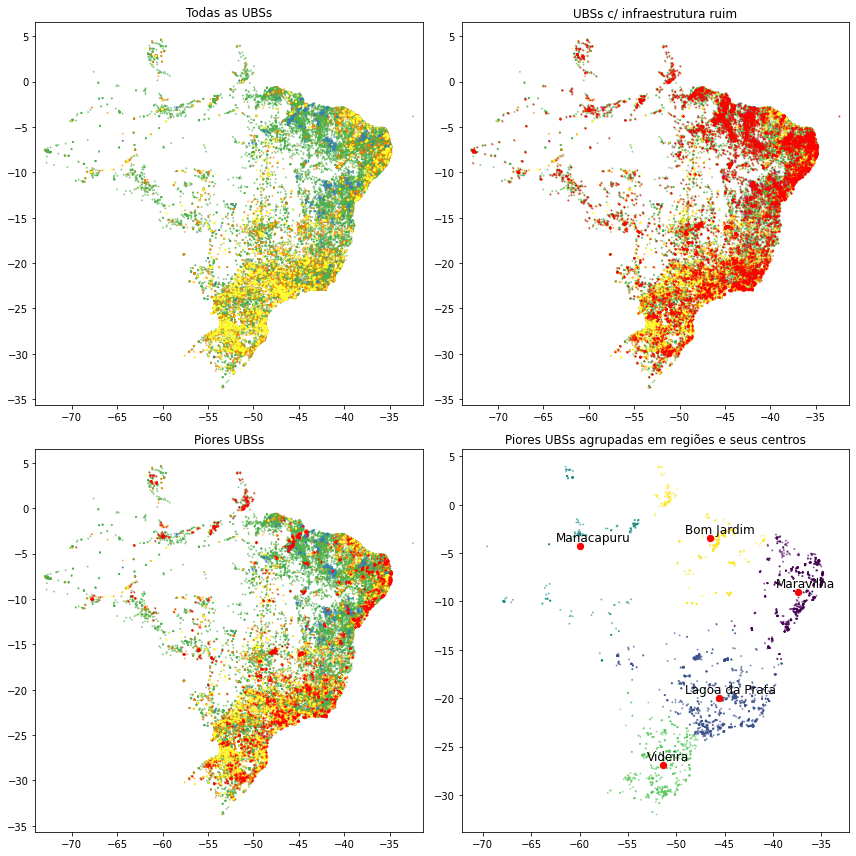

In [33]:
figure_size()

plt.subplot(2,2,1)
print_map(ubs, show=False, size=1, x=X, y=Y)
plt.title('Todas as UBSs')

plt.subplot(2,2,2)
print_map(ubs, show=False, size=1, x=X, y=Y)
print_map(ubs_space, show=False, color='red', size=1, x=X, y=Y)
plt.title('UBSs c/ infraestrutura ruim')

plt.subplot(2,2,3)
print_map(ubs, show=False, size=1, x=X, y=Y)
print_map(bad_primary_ubs, show=False, color='red', size=1, x=X, y=Y)
plt.title('Piores UBSs')

# Grouped by K-means
fits = bad_primary_ubs[[Y, X]]
kmeans = KMeans(n_clusters=5).fit(fits)
centroids = kmeans.cluster_centers_
closest, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, fits)
closest

plt.subplot(2,2,4)
plt.axis('equal')
plt.title('Piores UBSs agrupadas em regiões e seus centros')
plt.scatter(bad_primary_ubs[X], bad_primary_ubs[Y], c= kmeans.labels_.astype(float), s=1, alpha=0.5)
plt.scatter(centroids[:, 1], centroids[:, 0], c='red', s=40)

for i in range(len(centroids)):
    index = closest[i]
    city = bad_primary_ubs.iloc[index]['dsc_cidade']
    
    x = centroids[i, 1]-(0.25*len(city))
    y = centroids[i, 0]+0.5
    
    plt.text(x, y, city, fontsize=12)

# Show all graphics
plt.tight_layout()

In [34]:
# UBSs that could be prioritized
cities = bad_primary_ubs.iloc[closest]

conditions = False
for i, row in cities.iterrows():
    conditions = conditions | (bad_primary_ubs['dsc_cidade'] == row['dsc_cidade'])

ubs_selected_cities = bad_primary_ubs[conditions]
print(ubs_selected_cities.shape[0])

ubs_selected_cities

44


,vlr_latitude,vlr_longitude,cod_munic,cod_cnes,nom_estab,dsc_endereco,dsc_bairro,dsc_cidade,dsc_telefone,dsc_estrut_fisic_ambiencia,...,nota,data_ref,estado,populacao,nota_infra,nota_potencial,nota_qualidade,label_prioridade,label,cor
20462,-9.218184,-37.477734,270460,2720353,POSTO DE SAUDE CAPIA NOVO,SITIO CAPIA NOVO,ZONA RURAL,Maravilha,(82)6251146,0,...,10.000000,2011-12-31,AL,9004,0,5,0,0,2. Médio/baixo,"[0.277941, 0.056324, 0.381191, 1.0]"
20442,-9.212573,-37.381711,270460,2720809,POSTO DE SAUDE JOSE H DA SILVA,SITIO LAGOA BONITA,ZONA RURAL,Maravilha,(82)6251146,0,...,10.000000,2011-12-31,AL,9004,0,5,0,0,2. Médio/baixo,"[0.277941, 0.056324, 0.381191, 1.0]"
42588,-3.300450,-60.621500,130250,5015820,UBS DA FAMILIA VILA RICA DE CAVIANA,VILA DE CAVIANA,ZONA RURAL,Manacapuru,92 3361-1151,0,...,9.721649,2011-12-31,AM,98502,0,4.86082,0.139175,0,2. Médio/baixo,"[0.283091, 0.110553, 0.431554, 1.0]"
42595,-3.296939,-60.443087,130250,2013215,UBS DA FAMILIA COSTA DA BELA VISTA,ARAPAPA I,ZONA RURAL,Manacapuru,Não se aplica,0,...,9.721649,2011-12-31,AM,98502,0,4.86082,0.139175,0,2. Médio/baixo,"[0.283091, 0.110553, 0.431554, 1.0]"
42597,-3.602282,-60.818167,130250,2013185,UBS DA FAMILIA NOSSA SENHORA DO CARMO,BOCA DO JACARE,ZONA RURAL,Manacapuru,Não se aplica,0,...,9.721649,2011-12-31,AM,98502,0,4.86082,0.139175,0,2. Médio/baixo,"[0.283091, 0.110553, 0.431554, 1.0]"
12567,-7.810378,-35.634091,260220,2703254,POSTO DE SAUDE DE LAGOA DE CASA,SITIO LAGOA DE CASA,SITIO,Bom Jardim,Não se aplica,0,...,10.000000,2011-12-31,MA,41822,0,5,0,0,2. Médio/baixo,"[0.185556, 0.41857, 0.556753, 1.0]"
12369,-3.638266,-45.770524,210200,2530015,UNIDADE BASICA DE SAUDE DO ROSARIO,RUA DO COMERCIO,ROSARIO,Bom Jardim,(98) 3664 2130,0,...,10.000000,2011-12-31,MA,41822,0,5,0,0,2. Médio/baixo,"[0.185556, 0.41857, 0.556753, 1.0]"
12675,-3.568132,-46.022844,210200,2529963,UNIDADE BASICA DE SAUDE DA VILA BANDEIRANTES,RUA GRANDE,VILA BANDEIRANTES,Bom Jardim,9836726029,0,...,10.000000,2011-12-31,MA,41822,0,5,0,0,2. Médio/baixo,"[0.185556, 0.41857, 0.556753, 1.0]"
12387,-22.176000,-42.473230,330050,2296438,UNIDADE MEDICA DE FAMILIA THOMAZ CORREA DA ROCHA,RUA ALCIDES LIMA,BANQUETE,Bom Jardim,(22)25662766,0,...,10.000000,2011-12-31,MA,41822,0,5,0,0,2. Médio/baixo,"[0.185556, 0.41857, 0.556753, 1.0]"
12621,-3.608805,-45.529618,210200,2530023,UNIDADE BASICA DE SAUDE DO TIRIRICAL,BR 316,TIRIRICAL,Bom Jardim,(98) 3664 2130,0,...,10.000000,2011-12-31,MA,41822,0,5,0,0,2. Médio/baixo,"[0.185556, 0.41857, 0.556753, 1.0]"


Text(0.5, 1.0, 'UBSs de  pior qualidade por estado')

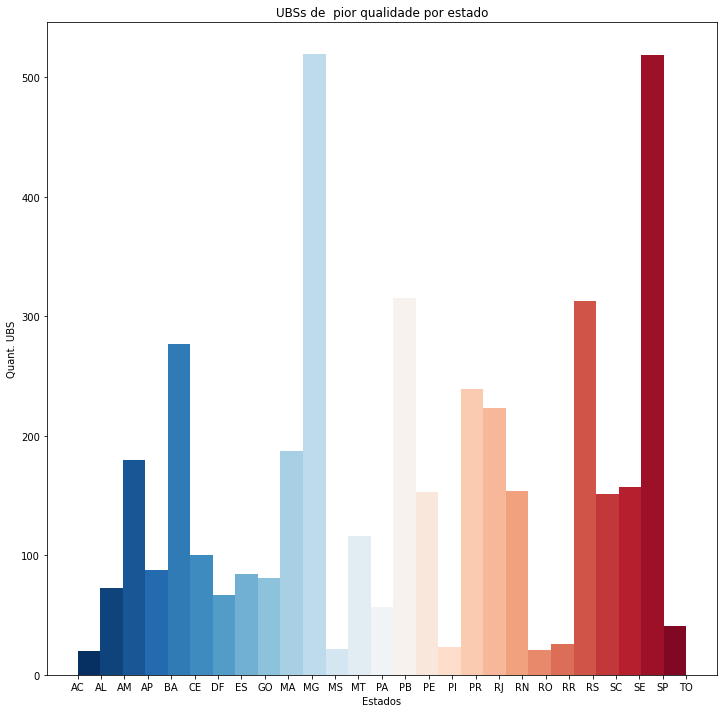

In [35]:
figure_size()

cm = plt.cm.RdBu_r

bad_ubs_hist, bins, patches = plt.hist(bad_primary_ubs['estado'], len(states), color='green')
for i, p in enumerate(patches):
    plt.setp(p, 'facecolor', cm(i/len(states)))

plt.ylabel('Quant. UBS')
plt.xlabel('Estados')
plt.title('UBSs de  pior qualidade por estado')

In [36]:
bins

array([ 0.        ,  0.96296296,  1.92592593,  2.88888889,  3.85185185,
        4.81481481,  5.77777778,  6.74074074,  7.7037037 ,  8.66666667,
        9.62962963, 10.59259259, 11.55555556, 12.51851852, 13.48148148,
       14.44444444, 15.40740741, 16.37037037, 17.33333333, 18.2962963 ,
       19.25925926, 20.22222222, 21.18518519, 22.14814815, 23.11111111,
       24.07407407, 25.03703704, 26.        ])

In [37]:
print('=== Qualidade das UBSs por estado (estimativa) ===');

for i in range(len(states)):
    state = states[i]
    bad_count = bad_ubs_hist[i]
    total_count = state_ubs_count_list[i]
    percentage = 100 * bad_count / total_count
    pacients_count = states_population[i] * percentage / 100

    print('UBSs entre as piores %s: %0.2f%% (%d de %d) | %d pessoas' % (state, percentage, bad_count, total_count, pacients_count))

=== Qualidade das UBSs por estado (estimativa) ===
UBSs entre as piores AC: 6.85% (20 de 292) | 61265 pessoas
UBSs entre as piores AL: 4.69% (73 de 1557) | 157137 pessoas
UBSs entre as piores AM: 31.20% (180 de 577) | 1312631 pessoas
UBSs entre as piores AP: 48.35% (88 de 182) | 416681 pessoas
UBSs entre as piores BA: 5.49% (277 de 5042) | 820266 pessoas
UBSs entre as piores CE: 4.13% (100 de 2423) | 379162 pessoas
UBSs entre as piores DF: 50.76% (67 de 132) | 1550719 pessoas
UBSs entre as piores ES: 9.27% (84 de 906) | 376799 pessoas
UBSs entre as piores GO: 5.11% (81 de 1584) | 363760 pessoas
UBSs entre as piores MA: 6.69% (187 de 2797) | 475663 pessoas
UBSs entre as piores MG: 8.85% (520 de 5876) | 1884306 pessoas
UBSs entre as piores MS: 2.65% (22 de 830) | 74465 pessoas
UBSs entre as piores MT: 12.00% (116 de 967) | 423000 pessoas
UBSs entre as piores PA: 3.49% (57 de 1633) | 303351 pessoas
UBSs entre as piores PB: 9.14% (315 de 3446) | 369231 pessoas
UBSs entre as piores PE: 5.49

In [38]:
# Worst pacients by city
for index, row in population.iterrows():
    city = row['dsc_cidade']
    city_ubs = ubs[ubs['dsc_cidade'] == city]
    
    ubs_count = city_ubs.shape[0]
    bad_ubs_count = bad_primary_ubs[bad_primary_ubs['dsc_cidade'] == city].shape[0]
    percentage = bad_ubs_count / ubs_count if ubs_count != 0 else 1
    pacients = math.ceil(row['populacao'] * percentage)
        
    population.loc[population['dsc_cidade'] == city, 'piores_pacientes'] = pacients
    
# Worst pacients by state
worst_pacients_states = []
for state in states:
    condition = population['estado'] == state
    cities = population[condition]
    rows_sum = cities.sum(axis = 0, skipna = True)
    worst_pacients_states.append(rows_sum['piores_pacientes'])
    
worst_pacients_states

[13348.0,
 835633.0,
 1738372.0,
 412181.0,
 1560304.0,
 325077.0,
 1550720.0,
 301083.0,
 515032.0,
 662888.0,
 2041100.0,
 153424.0,
 773106.0,
 853330.0,
 684749.0,
 692097.0,
 54716.0,
 671847.0,
 1731058.0,
 699637.0,
 177050.0,
 12252.0,
 1448635.0,
 466770.0,
 322636.0,
 3732357.0,
 129892.0]

In [39]:
print('=== Qualidade das UBSs por estado (estimativa por cidade) ===');
total = 0

for i in range(len(states)):
    state = states[i]

    total_count = states_population[i]
    bad_count = worst_pacients_states[i]
    percentage = 100 * bad_count / total_count
    total += bad_count

    print('Pacientes em pior atendimento em %s: %0.2f%% (%d de %d)' % (state, percentage, bad_count, total_count))
    
print('Total: %d pacientes' % total)

=== Qualidade das UBSs por estado (estimativa por cidade) ===
Pacientes em pior atendimento em AC: 1.49% (13348 de 894470)
Pacientes em pior atendimento em AL: 24.93% (835633 de 3351543)
Pacientes em pior atendimento em AM: 41.31% (1738372 de 4207714)
Pacientes em pior atendimento em AP: 47.83% (412181 de 861773)
Pacientes em pior atendimento em BA: 10.45% (1560304 de 14930634)
Pacientes em pior atendimento em CE: 3.54% (325077 de 9187103)
Pacientes em pior atendimento em DF: 50.76% (1550720 de 3055149)
Pacientes em pior atendimento em ES: 7.41% (301083 de 4064052)
Pacientes em pior atendimento em GO: 7.24% (515032 de 7113540)
Pacientes em pior atendimento em MA: 9.32% (662888 de 7114598)
Pacientes em pior atendimento em MG: 9.59% (2041100 de 21292666)
Pacientes em pior atendimento em MS: 5.46% (153424 de 2809394)
Pacientes em pior atendimento em MT: 21.92% (773106 de 3526220)
Pacientes em pior atendimento em PA: 9.82% (853330 de 8690745)
Pacientes em pior atendimento em PB: 16.95% (68

# Looking for specific cities
Using the data above, we can build maps of UBSs by city, as in this example of the city of São Paulo.

(421, 23)
(1, 23)
(1, 23)


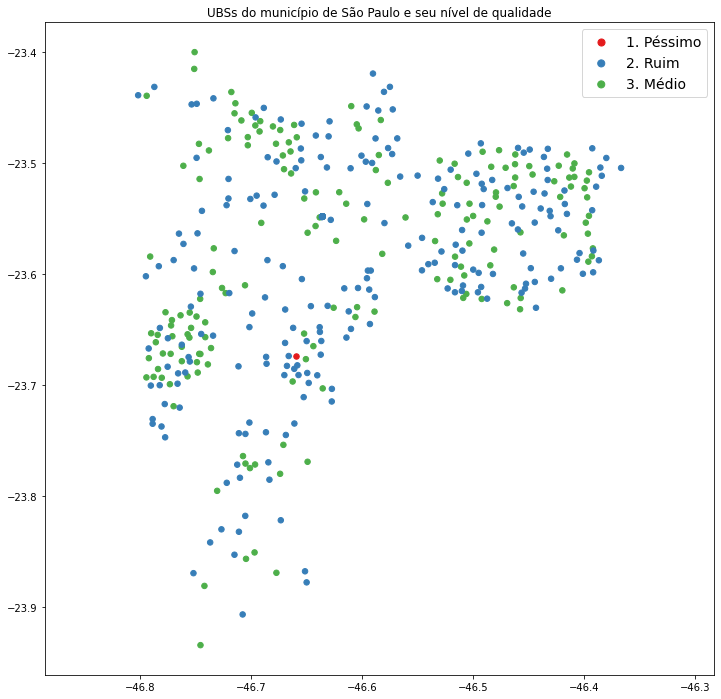

In [40]:
color_by_quality(ubs, 'nota_qualidade')

sp = ubs[ubs['dsc_cidade'] == 'São Paulo']
bad_sp = bad_primary_ubs[bad_primary_ubs['dsc_cidade'] == 'São Paulo']
infra_sp = selected_ubs[selected_ubs['dsc_cidade'] ==  'São Paulo']

print(sp.shape)
print(infra_sp.shape)
print(bad_sp.shape)

figure_size()
print_map(sp, show=False, size=30, alpha=1, x=X, y=Y)

legend_for_map()
plt.title('UBSs do município de São Paulo e seu nível de qualidade')

plt.show()